In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul  9 20:48:41 2020

@author: stc
"""
##############################################################################
# NOTHING NEED TO BE CHANGED IN THIS CELL
##############################################################################

import numpy as np
from matplotlib import pyplot as plt
import random
from scipy.optimize import curve_fit
from scipy.stats import pearsonr




class wows_model1(object):
    
    def __init__(self,N_players=24*10):
        
        self.N_players = N_players
        self.playernumbers = np.arange(0,self.N_players,1)
        self.players = np.arange(0,self.N_players,1)
        self.winrate_0 = np.zeros(self.N_players)
        self.playerbase = np.zeros((self.N_players,3))
        self.N_battles = int(self.N_players/24)
        
        
        print(' - - Playerbase object created - - ')


    def define_skill(self,average=50,sigma=10):
        self.average = average
        self.sigma = sigma
        self.skill = np.random.normal(scale=self.sigma,size=self.N_players)+self.average
        self.playerbase[:,0]=self.skill[:]
        print(' - - skill levels have been defined - - ')

####################################

####################################

# Below are cases for the case of equal distribution of games
# in other words for every iteration the whole playerbase is playing a game
# with randomly generated teams

    # ####################################
    # This is the prototypical NO RNG case meaning the outcome of a match
    # is entirely deterministic and based on the average skill of a team
    # THIS IS NOT HOW WOWS WORKS
    # JUST FOR COMPARISON 



    def gen_data_mod1_NO_RNG(self,n_iter):
        self.playerbase2 = np.copy(self.playerbase)
        self.WR_differences = np.zeros(n_iter*self.N_battles)
        for m in range(0,n_iter,1):
            # shuffles the playerlist
            np.random.shuffle(self.players)        
           
            # separate the playerlist into pieces of 24
            # this generates the battle lineups
            # ensuring everyone has am equal number of battles at the end
            
            self.battle_lineups = np.split(self.players,self.N_battles)
            
            ##########
            # This is the loop where all the games in one Matchmaking round are 'played'
            # The shuffled player list is evenly split into parts of 24 players
            # the first 12 are greens, the second 12 are reds
            
            
            for k in range(0,self.N_battles,1):
                
                # Determine the average skill of the players in the green portion    
                self.skill_green = 0
                for l in range(0,12,1):
                    self.current_player_skill = self.playerbase2[self.battle_lineups[k][l],0]
                    self.skill_green += self.current_player_skill/12
                    
                # Determine the average skill of the players in the red portion    
                self.skill_red = 0
                for l in range(12,24,1):
                    self.current_player_skill = self.playerbase2[self.battle_lineups[k][l],0]
                    self.skill_red += self.current_player_skill/12
               
                #######
                # The outcome of the battle is determined here and the list is updated
                # In this version it is entirely up to the skill of the players
                # This is the "NO RNG" case
                self.WR_differences[m*self.N_battles+k] = (self.skill_green-self.skill_red)
                
                if self.skill_green > self.skill_red:
                    for l in range(0,12,1):
                        self.playerbase2[self.battle_lineups[k][l],1] += 1
                        
                        
                if self.skill_green < self.skill_red:
                    for l in range(12,24,1):
                        self.playerbase2[self.battle_lineups[k][l],1] += 1
                        
                        
                if self.skill_green == self.skill_red:
                    for l in range(0,24,1):
                        self.playerbase2[self.battle_lineups[k][l],1] += 0.5
            
        return self.playerbase2,self.WR_differences
        
#####################################
# This is the second model WITH RNG 
# Meaning more skill increases the likelihood of winning
# there is a RNG parameter indicating how strong skill should influence the outcome

# mod1_RNG_1 uses a random distribution of 'RNG_skill" added to one team.
# this added 'skill' can be positive or negative and represents basically good or bad luck


    def gen_data_mod1_RNG_1(self,n_iter,RNG):
        self.playerbase2 = np.copy(self.playerbase)
        self.WR_differences = np.zeros(n_iter*self.N_battles)
        for m in range(0,n_iter,1):
            # shuffles the playerlist
            np.random.shuffle(self.players)        
            
            # separate the playerlist into pieces of 24
            # this generates the battle lineups
            # ensuring everyone has am equal number of battles at the end
            
            self.battle_lineups = np.split(self.players,self.N_battles)
            
            ##########
            # This is the loop where all the games in one Matchmaking round are 'played'
            # The shuffled player list is evenly split into parts of 24 players
            # the first 12 are greens, the second 12 are reds
            
            
            for k in range(0,self.N_battles,1):
                
                # Determine the average skill of the players in the green portion    
                self.skill_green = 0
                for l in range(0,12,1):
                    self.current_player_skill = self.playerbase2[self.battle_lineups[k][l],0]
                    self.skill_green += self.current_player_skill/12
                    
                # Determine the average skill of the players in the red portion    
                self.skill_red = 0
                for l in range(12,24,1):
                    self.current_player_skill = self.playerbase2[self.battle_lineups[k][l],0]
                    self.skill_red += self.current_player_skill/12
               

                
                self.random = (np.random.random()*(2*RNG)-RNG)/12
                self.WR_differences[m*self.N_battles+k] = self.random
                # self.WR_differences[m*self.N_battles+k] = (self.skill_green+self.random -self.skill_red)
                
                if self.skill_green+self.random > self.skill_red:
                    for l in range(0,12,1):
                        self.playerbase2[self.battle_lineups[k][l],1] += 1
                        
                        
                if self.skill_green+self.random < self.skill_red:
                    for l in range(12,24,1):
                        self.playerbase2[self.battle_lineups[k][l],1] += 1
                        
                        
                if self.skill_green+self.random == self.skill_red:
                    for l in range(0,24,1):
                        self.playerbase2[self.battle_lineups[k][l],1] += 0.
        return self.playerbase2,self.WR_differences

#################################
# mod1_RNG_NORMAL uses a normal distribution of 'RNG_skill" added to one team.
# normal distribution differs from random in that not all values are equally likely and 
# values are on a bell curve instead
# this added 'skill' can be positive or negative and represents basically good or bad luck


    def gen_data_mod1_RNG_NORMAL(self,n_iter,RNG):
        self.playerbase2 = np.copy(self.playerbase)
        self.WR_differences = np.zeros(n_iter*self.N_battles)
        for m in range(0,n_iter,1):
            # shuffles the playerlist
            np.random.shuffle(self.players)        
            
            # separate the playerlist into pieces of 24
            # this generates the battle lineups
            # ensuring everyone has am equal number of battles at the end
            
            self.battle_lineups = np.split(self.players,self.N_battles)
            
            ##########
            # This is the loop where all the games in one Matchmaking round are 'played'
            # The shuffled player list is evenly split into parts of 24 players
            # the first 12 are greens, the second 12 are reds
            
            
            for k in range(0,self.N_battles,1):
                
                # Determine the average skill of the players in the green portion    
                self.skill_green = 0
                for l in range(0,12,1):
                    self.current_player_skill = self.playerbase2[self.battle_lineups[k][l],0]
                    self.skill_green += self.current_player_skill/12
                    
                # Determine the average skill of the players in the red portion    
                self.skill_red = 0
                for l in range(12,24,1):
                    self.current_player_skill = self.playerbase2[self.battle_lineups[k][l],0]
                    self.skill_red += self.current_player_skill/12
               
                #######
                # The outcome of the battle is determined here and the list is updated
                # In this version it is entirely up to the skill of the players
                # This is the "NO RNG" case
                
                self.random = (np.random.randn()*RNG)/12
                self.WR_differences[m*self.N_battles+k] = self.random
                # self.WR_differences[m*self.N_battles+k] = (self.skill_green+self.random -self.skill_red)
                
                if self.skill_green+self.random > self.skill_red:
                    for l in range(0,12,1):
                        self.playerbase2[self.battle_lineups[k][l],1] += 1
                        
                        
                if self.skill_green+self.random < self.skill_red:
                    for l in range(12,24,1):
                        self.playerbase2[self.battle_lineups[k][l],1] += 1
                        
                        
                if self.skill_green+self.random == self.skill_red:
                    for l in range(0,24,1):
                        self.playerbase2[self.battle_lineups[k][l],1] += 0.5
                        
        return self.playerbase2,self.WR_differences     
              
########################################################################    
    # SECOND TYPE OF MATCHMAKING
    # Employs non-uniform number of games per player
    #
    # This is somewhat closer to reality than the simple cases 1    
    # 
    # instead of everyone playing the same number of games, players are randomly chosen for games
    # every players has an equal chance to play a battle
    
       
    # ####################################

    #
    # This is the prototypical NO RNG case meaning the outcome of a match
    # is entirely deterministic and based on the average skill of a team
    # THIS IS NOT HOW WOWS WORKS
    # JUST FOR COMPARISON 



    def gen_data_mod2_NO_RNG(self,n_iter):
        self.playerbase2 = np.copy(self.playerbase)
        self.WR_differences = np.zeros(n_iter)
        
        
        for m in range(0,n_iter,1):
            # shuffles the playerlist
            np.random.shuffle(self.players)        
           
            # Instead of shuffling the playerbase and then dividing them
            # into pieces of 24 we are now going to sample 24 players
            
            
            self.battle_team = np.random.choice(self.players,size=24,replace=False)
            
            ##########
            # The selected 24 player list is evenly split into parts
            # the first 12 are greens, the second 12 are reds
            
            # Determine the average skill of the players in the green portion    
            self.skill_green = 0
            for l in range(0,12,1):
                self.current_player_skill = self.playerbase2[self.battle_team[l],0]
                self.skill_green += self.current_player_skill/12
                
            # Determine the average skill of the players in the red portion    
            self.skill_red = 0
            for l in range(12,24,1):
                self.current_player_skill = self.playerbase2[self.battle_team[l],0]
                self.skill_red += self.current_player_skill/12
           
            #######
            # The outcome of the battle is determined here and the list is updated
            # In this version it is entirely up to the skill of the players
            # This is the "NO RNG" case
            self.WR_differences[m] = (self.skill_green-self.skill_red)
            
            self.playerbase2[self.battle_team[:],2] += 1
            
            if self.skill_green > self.skill_red:
                for l in range(0,12,1):
                    self.playerbase2[self.battle_team[l],1] += 1
                    
                    
            if self.skill_green < self.skill_red:
                for l in range(12,24,1):
                    self.playerbase2[self.battle_team[l],1] += 1
                    
                    
            if self.skill_green == self.skill_red:
                for l in range(0,24,1):
                    self.playerbase2[self.battle_team[l],1] += 0.5
        
        return self.playerbase2,self.WR_differences    
    
    
    # ####################################
    # instead of everyone playing the same number of games, players are randomly chosen for games
    # The chance for a specific player to play a battle is given by another distribution
    # This is designed to account for differences in players activity i.e. number of battles per time
    #
    # This is the prototypical NO RNG case meaning the outcome of a match
    # is entirely deterministic and based on the average skill of a team
    # THIS IS NOT HOW WOWS WORKS
    # JUST FOR COMPARISON 



    def gen_data_mod3_NO_RNG(self,n_iter,N_battles_per_iter=1):
        self.playerbase2 = np.copy(self.playerbase)
        self.WR_differences = np.zeros(n_iter)
        self.battle_density = np.zeros(len(self.playerbase))
        self.battle_density = np.exp(-0.002*np.arange(self.N_players,0,-1))
        self.prop_sum = np.sum(self.battle_density)
        self.battle_density = self.battle_density/self.prop_sum
        print(self.battle_density)        
        plt.plot(self.battle_density)
        
        for m in range(0,n_iter,1):
                       
            # Instead of shuffling the playerbase and then dividing them
            # into pieces of 24 we are now going to sample 24 players
                        
            self.battle_team = np.random.choice(self.players,size=24,replace=False,p=self.battle_density)
            
            ##########
            # The selected 24 player list is evenly split into parts
            # the first 12 are greens, the second 12 are reds
            
            # Determine the average skill of the players in the green portion    
            self.skill_green = 0
            for l in range(0,12,1):
                self.current_player_skill = self.playerbase2[self.battle_team[l],0]
                self.skill_green += self.current_player_skill/12
                
            # Determine the average skill of the players in the red portion    
            self.skill_red = 0
            for l in range(12,24,1):
                self.current_player_skill = self.playerbase2[self.battle_team[l],0]
                self.skill_red += self.current_player_skill/12
           
            #######
            # The outcome of the battle is determined here and the list is updated
            # In this version it is entirely up to the skill of the players
            # This is the "NO RNG" case
            self.WR_differences[m] = (self.skill_green-self.skill_red)
            
            self.playerbase2[self.battle_team[:],2] += 1
            
            if self.skill_green > self.skill_red:
                for l in range(0,12,1):
                    self.playerbase2[self.battle_team[l],1] += 1
                    
                    
            if self.skill_green < self.skill_red:
                for l in range(12,24,1):
                    self.playerbase2[self.battle_team[l],1] += 1
                    
                    
            if self.skill_green == self.skill_red:
                for l in range(0,24,1):
                    self.playerbase2[self.battle_team[l],1] += 0.5
        
        return self.playerbase2,self.WR_differences  
    

# Define some helperfunctions
#-------------------------
# define fitfunction
def line(x,m,b):
    f=m*x+b
    return f
#------------------------

    
##############################################################################
##############################################################################






In [2]:
#################
# Setup of calculations
# Running this might take a few minutes, depending on values input here
# DO NOT CLOSE OR CANCEL ETC
# Calculations last anywhere from seconds to minutes, this is normal!!
#################

#################
# Number of games to be simulated
# NOTE: For model 1 this is the number of iterations, i.e. every player will have played this many games
#       For model 2 and 3 this is the total number of games, with most players having played much fewer games
#       Consequently, a lower number is sufficient for model 1 and calculation times are much longer!
n_games = 20

#################
# Number of players to be simulated
# Should be a multiple of 24 for ease of use
# 24*100 should be enough for most applications
n_players = 24*100

#################
# Define the skill distribution
# The sigma value is the width of the 'skill' or 'WR' distribution in WOWS
# a value between 2 and 5 should be adequate
sigma = 4.5

#################
# The RNG used for the RNG based models
# this gets normalized to 1/12th, so the number corresponds to the skill of a single 'extra player' 
# 
RNG=25


my_players = wows_model1(N_players=n_players)
my_players.define_skill(sigma=sigma)
playernumbers = my_players.playernumbers
skill = my_players.playerbase[:,0]

#################
# Generate the results based on one of the above models:
# You can chose the various models from here
# Models 2 and 3 are not listed here, but can be added.

# playerbase2, WR_diffs2 = my_players.gen_data_mod1_NO_RNG(n_games)
playerbase2, WR_diffs2 = my_players.gen_data_mod1_RNG_1(n_games, RNG)
# playerbase2, WR_diffs2 = my_players.gen_data_mod1_RNG_NORMAL(n_games, 50)




battles = np.arange(0,len(WR_diffs2),1)


 - - Playerbase object created - - 
 - - skill levels have been defined - - 


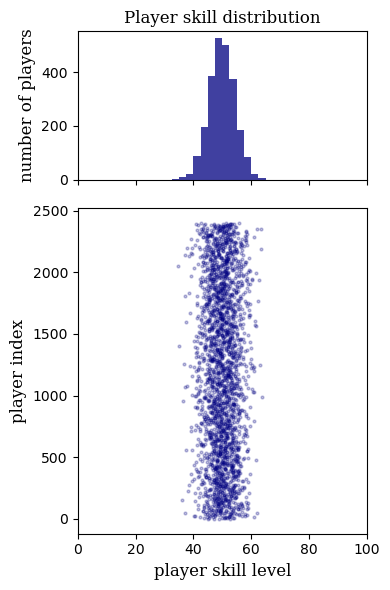

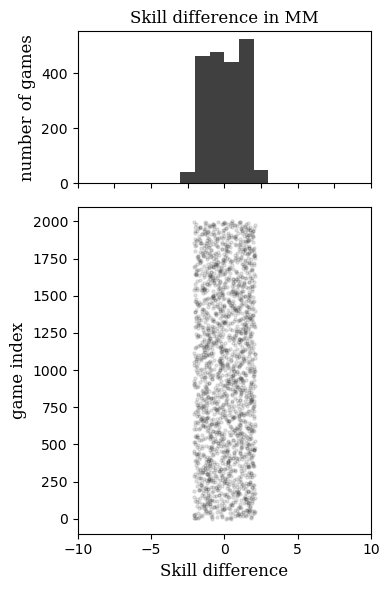

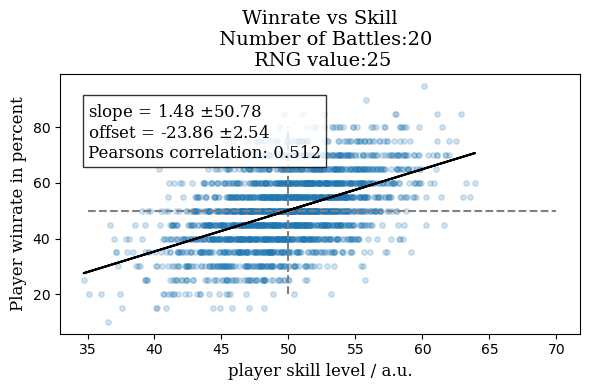

In [4]:
# ############################################################################
# # VISUALIZATION SECTION
# # 
# #
####################################################################
# Figures are made below here:


font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        }


####################################################################
# Figure 1
# This figure shows the player skill plotted vs the index number
# on top of that is the corresponding histogram
# this shows how the 'skill' of the population is dristributed
fig = plt.figure(figsize=(4,6),dpi=100)
ax = plt.subplot2grid((3,1),(1,0),colspan=1, rowspan=2)
plt.scatter(skill,playernumbers,color='navy',alpha=0.25,s=4)
ax.set_ylabel('player index', fontdict=font)
ax.set_xlabel('player skill level', fontdict=font)
plt.xlim(0, 100)
ax1 = plt.subplot2grid((3,1),(0,0),colspan=1, rowspan=1)
levels = np.arange(0,102.5,2.5)
n, bins, patches = plt.hist(skill,levels, density=False,facecolor='navy',alpha=0.75)
plt.xlim(0, 100)
plt.tick_params(axis='x', which='both', labelbottom=False, bottom=True, labelsize=8)
plt.title('Player skill distribution', fontdict=font)
ax1.set_ylabel('number of players', fontdict=font)
plt.tight_layout()
plt.show()
fig.savefig('Skill_distribution_'+str(n_games)+'_'+str(n_players)+'_'+str(sigma)+str(RNG)+'.png',dpi=100, format='png',bbox_inches='tight', pad_inches=0.1) 
plt.close()


####################################################################
# Figure 2
# This figure shows the difference in avg. skill of the match
# The MM is deterministic, so the teamn with more 'skill' wins
# 
# However, the RNG models add/subtract some random amount of skill to one of the teams
# This serves to simulate various amounts of RNG in the game
# All of this is of course very basic

fig = plt.figure(figsize=(4,6),dpi=100)
ax = plt.subplot2grid((3,1),(1,0),colspan=1, rowspan=2)
plt.scatter(WR_diffs2,battles,color='black',alpha=0.1,s=5)
ax.set_ylabel('game index', fontdict=font)
ax.set_xlabel('Skill difference', fontdict=font)
plt.xlim(-10, 10)
ax1 = plt.subplot2grid((3,1),(0,0),colspan=1, rowspan=1)
levels = np.arange(-100,100,1)
n, bins, patches = plt.hist(WR_diffs2,levels, density=False,facecolor='black',alpha=0.75)
plt.xlim(-10, 10)
plt.tick_params(axis='x', which='both', labelbottom=False, bottom=True, labelsize=8)
plt.title('Skill difference in MM', fontdict=font)
ax1.set_ylabel('number of games', fontdict=font)
plt.tight_layout()
plt.show()
fig.savefig('Skill_differences_'+str(n_games)+'_'+str(n_players)+'_'+str(sigma)+str(RNG)+'.png',dpi=100, format='png',bbox_inches='tight', pad_inches=0.1) 
plt.close()

####################################################################
# Figure 3
# Skill level vs Winrate

WR_list = np.arange(0,100,1000)

popt1, pcov1 = curve_fit(line,playerbase2[:,0],100*playerbase2[:,1]/n_games,p0=(1,1),maxfev=1500)
# calculate Pearson's correlation
corr, _ = pearsonr(playerbase2[:,0], 100*playerbase2[:,1]/n_games)


fig = plt.figure(figsize=(6,4),dpi=100)
plt.title('Winrate vs Skill'+'\n  Number of Battles:'+str(n_games)+'\n RNG value:'+str(RNG),fontdict=font,size=14)
plt.scatter(playerbase2[:,0],100*playerbase2[:,1]/n_games,alpha=0.2,s=15)
plt.plot(playerbase2[:,0],line(playerbase2[:,0],*popt1),color='k')

cmp1=r'slope = '+str(np.round(popt1[0],2))+' $\pm$'+str(np.round(np.sqrt(pcov1[0,0])*1000,2))+'\n'
cmp2=r'offset = '+str(np.round(popt1[1],2))+' $\pm$'+str(np.round(np.sqrt(pcov1[1,1]),2))+'\n'
cmp3='Pearsons correlation: %.3f' % corr
plt.text(35,69,cmp1+cmp2+cmp3,fontsize=12,fontdict=font,bbox=dict(boxstyle='square',ec=(0.,0.,0.),fc=(1.,1.,1.),alpha=0.8))
plt.hlines(50, 35, 70,colors='gray',linestyle='--')
plt.vlines(50, 20, 80,colors='gray',linestyle='--')
# plt.scatter(playerbase2[:,0],100*playerbase2[:,1]/playerbase2[:,2],c=playerbase2[:,2],cmap='hsv',alpha=0.2,s=15)
# plt.scatter(playernumbers,skill2,color='tab:red')
ax = plt.gca()
ax.set_xlabel('player skill level / a.u.', fontdict=font)
ax.set_ylabel('Player winrate in percent', fontdict=font)
plt.tight_layout()
# plt.show()
fig.savefig('Skill_WR_correlation_'+str(n_games)+'_'+str(n_players)+'_'+str(sigma)+str(RNG)+'.png',dpi=100, format='png',bbox_inches='tight', pad_inches=0.1) 
plt.show()
plt.close()
